### Imports, Directory and Path

In [1]:
import os
from os import path
import sys
import time

import numpy as np
import pandas as pd
from scipy.stats.mstats import zscore

import matplotlib.pyplot as plt
% matplotlib inline

In [3]:
BASE_DIR = "../AmesHousing/"
sys.path.append(path.abspath(BASE_DIR+'SupportModule/'))

import lookup_dir_names as DIR
import fnc_featureSelection as FS

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

### Training data 
Select features and perform feature engineering

In [6]:
trn = pd.read_csv(DIR.DATA_IN+"train.csv")
num_df, ctg_df, dummy_df = FS.combineFeatures_01(trn)
target_df = trn['SalePrice']

print(num_df.shape)
print(ctg_df.shape)
print(dummy_df.shape)
print(target_df.shape)

(1460, 7)
(1460, 5)
(1460, 54)
(1460,)


**Column names**

In [10]:
num_df.columns.values

array(['TotLotSF', 'TotFlrSF', 'TotalBsmtSF', 'TotNumBath', 'GarageArea',
       'PorchArea', 'PoolArea'], dtype=object)

In [11]:
ctg_df.columns.values

array(['Year', 'isGarage', 'isFireplace', 'isPorch', 'isPool'], dtype=object)

In [12]:
dummy_df.columns.values

array(['GarageCars_0', 'GarageCars_1', 'GarageCars_2', 'GarageCars_3',
       'GarageCars_4', 'OverallQual_1', 'OverallQual_10', 'OverallQual_2',
       'OverallQual_3', 'OverallQual_4', 'OverallQual_5', 'OverallQual_6',
       'OverallQual_7', 'OverallQual_8', 'OverallQual_9', 'OverallCond_1',
       'OverallCond_2', 'OverallCond_3', 'OverallCond_4', 'OverallCond_5',
       'OverallCond_6', 'OverallCond_7', 'OverallCond_8', 'OverallCond_9',
       'Neighborhood_Blmngtn', 'Neighborhood_Blueste',
       'Neighborhood_BrDale', 'Neighborhood_BrkSide',
       'Neighborhood_ClearCr', 'Neighborhood_CollgCr',
       'Neighborhood_Crawfor', 'Neighborhood_Edwards',
       'Neighborhood_Gilbert', 'Neighborhood_IDOTRR',
       'Neighborhood_MeadowV', 'Neighborhood_Mitchel',
       'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes',
       'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer',
       'Neighborhoo

# Modeling

In [15]:
def featureNorm(Features):
    featnorm = StandardScaler()
    normFeatures = featnorm.fit_transform(Features)
    return normFeatures
    
def splitTrainTest(X, Y, split_size=0.3, seed=42):
    Xtrn, Xtest, Ytrn, Ytest = train_test_split(X, Y, test_size=split_size, random_state=seed)
    return Xtrn, Xtest, Ytrn, Ytest
    

def applyLinearRegression(Xtrn, Xtest, Ytrn, Ytest):
    lr = LinearRegression() #define model
    lr_model = lr.fit(Xtrn, Ytrn) #train model
    Ypred = lr_model.predict(Xtest) #apply model to make prediction  
    trn_score = lr_model.score(Xtrn, Ytrn) # compute score (R-sq by default)
    test_score = lr_model.score(Xtest, Ytest)
    return trn_score, test_score, Ypred


def applyLinearRegressionCV(X, Y):
    #define model
    lr = LinearRegression()  
    scores = cross_val_score(lr, X, Y, cv=10)
    return scores

### 1 A
Use numerical fetures only.   
Standarize X   
linear Y

In [19]:
X = num_df
Y = target_df

X_n = featureNorm(X)
Y_log = target_df.apply(np.log)

Xtrn, Xtest, Ytrn, Ytest = splitTrainTest(X_n, Y, split_size=0.3, seed = 1000)
trn_score, test_score, Ypred = applyLinearRegression(Xtrn, Xtest, Ytrn, Ytest)
cv_scores = applyLinearRegressionCV(X_n, Y)

print("Results from linear regression:")
print("R-sq on training data: ", trn_score)
print("R-sq on test data: ", test_score)

print(" ")
print("Cross validation scores:", cv_scores)

Results from linear regression:
R-sq on training data:  0.692524092863
R-sq on test data:  0.686489434819
 
Cross validation scores: [ 0.74404876  0.77427744  0.79816051  0.64846946  0.72362622  0.76146566
  0.68727391  0.69678864  0.33593079  0.7088964 ]


### 1 B
Use numerical fetures only.  
Standarize X  
log transform Y  

In [20]:
X = num_df
Y = target_df

X_n = featureNorm(X)
Y_log = target_df.apply(np.log)

Xtrn, Xtest, Ytrn, Ytest = splitTrainTest(X_n, Y_log, split_size=0.30, seed = 1000)
trn_score, test_score, Ypred = applyLinearRegression(Xtrn, Xtest, Ytrn, Ytest)
cv_scores = applyLinearRegressionCV(X_n, Y_log)

print("Results from linear regression:")
print("R-sq on training data: ", trn_score)
print("R-sq on test data: ", test_score)

print(" ")
print("Cross validation scores:", cv_scores)

Results from linear regression:
R-sq on training data:  0.723210417585
R-sq on test data:  0.724127517201
 
Cross validation scores: [ 0.76089571  0.82199001  0.80674839  0.68117925  0.75451625  0.76638756
  0.73175888  0.70706985  0.24434791  0.71690616]


### 2 A
Consider numerical and categorical variables. Instaed of "garage-area", "porch-area","pool-area" use their ctg.  
Standarize X   
linear Y

In [21]:
# apply feature standarization to num vars only
X_num_df = num_df.iloc[:, 0:4]
X_num_norm = featureNorm(X_num_df)
X_num_norm_df = pd.DataFrame(X_num_norm, columns=X_num_df.columns.values)

X = pd.concat( (X_num_norm_df, ctg_df), axis=1)
Y = target_df

X_n = featureNorm(X)
Y_log = target_df.apply(np.log)

Xtrn, Xtest, Ytrn, Ytest = splitTrainTest(X_n, Y, split_size=0.3, seed = 1000)
trn_score, test_score, Ypred = applyLinearRegression(Xtrn, Xtest, Ytrn, Ytest)
cv_scores = applyLinearRegressionCV(X_n, Y)

print("Features considered:")
print(X.columns.values)

print(" ")

print("Results from linear regression:")
print("R-sq on training data: ", trn_score)
print("R-sq on test data: ", test_score)

print(" ")

print("Cross validation scores:", cv_scores)

Features considered:
['TotLotSF' 'TotFlrSF' 'TotalBsmtSF' 'TotNumBath' 'Year' 'isGarage'
 'isFireplace' 'isPorch' 'isPool']
 
Results from linear regression:
R-sq on training data:  0.730063231009
R-sq on test data:  0.716624121746
 
Cross validation scores: [ 0.77229892  0.7788573   0.8280839   0.68081151  0.75875062  0.80247637
  0.76805926  0.76290335  0.3824367   0.7185192 ]


### 2 B
Consider numerical and categorical variables. Instaed of "garage-area", "porch-area","pool-area" use their ctg.   
Standarize X   
log transform Y

In [22]:
# apply feature standarization to num vars only
X_num_df = num_df.iloc[:, 0:4]
X_num_norm = featureNorm(X_num_df)
X_num_norm_df = pd.DataFrame(X_num_norm, columns=X_num_df.columns.values)

X = pd.concat( (X_num_norm_df, ctg_df), axis=1)
Y = target_df

X_n = featureNorm(X)
Y_log = target_df.apply(np.log)

Xtrn, Xtest, Ytrn, Ytest = splitTrainTest(X_n, Y_log, split_size=0.3, seed = 1000)
trn_score, test_score, Ypred = applyLinearRegression(Xtrn, Xtest, Ytrn, Ytest)
cv_scores = applyLinearRegressionCV(X_n, Y_log)

print("Features considered:")
print(X.columns.values)

print(" ")

print("Results from linear regression:")
print("R-sq on training data: ", trn_score)
print("R-sq on test data: ", test_score)

print(" ")

print("Cross validation scores:", cv_scores)

Features considered:
['TotLotSF' 'TotFlrSF' 'TotalBsmtSF' 'TotNumBath' 'Year' 'isGarage'
 'isFireplace' 'isPorch' 'isPool']
 
Results from linear regression:
R-sq on training data:  0.781213801858
R-sq on test data:  0.773537898972
 
Cross validation scores: [ 0.79701719  0.83542434  0.8462405   0.73781338  0.8257983   0.83371942
  0.80506734  0.79510348  0.36948277  0.73827961]


### 3 A
Consider numerical, categorical and dummy variables. Instaed of "garage-area", "porch-area","pool-area" use their ctg.  
Standarize X   
linear Y

In [23]:
# apply feature standarization to num vars only
X_num_df = num_df.iloc[:, 0:4]
X_num_norm = featureNorm(X_num_df)
X_num_norm_df = pd.DataFrame(X_num_norm, columns=X_num_df.columns.values)
X_num_norm_df.head()

X_n = pd.concat( (X_num_norm_df, ctg_df, dummy_df), axis=1)
Y = target_df

Y_log = target_df.apply(np.log)

Xtrn, Xtest, Ytrn, Ytest = splitTrainTest(X_n, Y, split_size=0.3, seed = 1000)
trn_score, test_score, Ypred = applyLinearRegression(Xtrn, Xtest, Ytrn, Ytest)
cv_scores = applyLinearRegressionCV(X_n, Y)

print("Features considered:")
print(X.columns.values)

print(" ")

print("Results from linear regression:")
print("R-sq on training data: ", trn_score)
print("R-sq on test data: ", test_score)

print(" ")

print("Cross validation scores:", cv_scores)

Features considered:
['TotLotSF' 'TotFlrSF' 'TotalBsmtSF' 'TotNumBath' 'Year' 'isGarage'
 'isFireplace' 'isPorch' 'isPool']
 
Results from linear regression:
R-sq on training data:  0.863275569873
R-sq on test data:  -4.0956672732e+18
 
Cross validation scores: [  8.83871784e-01   9.12186354e-01  -6.96891550e+21  -7.07578061e+21
   8.46925877e-01   8.74557853e-01   8.70256022e-01   8.59090110e-01
   6.77547913e-01   8.27274253e-01]


### 3 B
Consider numerical, categorical and dummy variables. Instaed of "garage-area", "porch-area","pool-area" use their ctg.  
Standarize X   
log transform Y

In [25]:
# apply feature standarization to num vars only
X_num_df = num_df.iloc[:, 0:4]
X_num_norm = featureNorm(X_num_df)
X_num_norm_df = pd.DataFrame(X_num_norm, columns=X_num_df.columns.values)

X_n = pd.concat( (X_num_norm_df, ctg_df, dummy_df), axis=1)
Y = target_df

Y_log = target_df.apply(np.log)

Xtrn, Xtest, Ytrn, Ytest = splitTrainTest(X_n, Y_log, split_size=0.3, seed = 1000)
trn_score, test_score, Ypred = applyLinearRegression(Xtrn, Xtest, Ytrn, Ytest)
cv_scores = applyLinearRegressionCV(X_n, Y_log)

print("Features considered:")
print(X.columns.values)

print(" ")

print("Results from linear regression:")
print("R-sq on training data: ", trn_score)
print("R-sq on test data: ", test_score)

print(" ")

print("Cross validation scores:", cv_scores)

Features considered:
['TotLotSF' 'TotFlrSF' 'TotalBsmtSF' 'TotNumBath' 'Year' 'isGarage'
 'isFireplace' 'isPorch' 'isPool']
 
Results from linear regression:
R-sq on training data:  0.884722390154
R-sq on test data:  -8.68686187073e+18
 
Cross validation scores: [  8.74300666e-01   9.15787626e-01  -3.91827308e+21  -5.43736777e+22
   8.71830605e-01   8.95516152e-01   8.86026079e-01   8.92535499e-01
   7.08535357e-01   8.38026335e-01]


### 4 Play with dummy features  
log transform Y

** 4A Garage (+ num features)**

In [26]:
# apply feature standarization to num vars only
X_num_df = num_df.iloc[:, 0:4]
X_num_norm = featureNorm(X_num_df)
X_num_norm_df = pd.DataFrame(X_num_norm, columns=X_num_df.columns.values)

# Select dummy
# Garage only

X_n = pd.concat( (X_num_norm_df, dummy_df.iloc[:, 0:5]), axis=1)
Y = target_df

Y_log = target_df.apply(np.log)

Xtrn, Xtest, Ytrn, Ytest = splitTrainTest(X_n, Y_log, split_size=0.3, seed = 1000)
trn_score, test_score, Ypred = applyLinearRegression(Xtrn, Xtest, Ytrn, Ytest)
cv_scores = applyLinearRegressionCV(X_n, Y_log)

print("Features considered:")
print(X_n.columns.values)

print(" ")

print("Results from linear regression:")
print("R-sq on training data: ", trn_score)
print("R-sq on test data: ", test_score)

print(" ")

print("Cross validation scores:", cv_scores)

Features considered:
['TotLotSF' 'TotFlrSF' 'TotalBsmtSF' 'TotNumBath' 'GarageCars_0'
 'GarageCars_1' 'GarageCars_2' 'GarageCars_3' 'GarageCars_4']
 
Results from linear regression:
R-sq on training data:  0.74327586807
R-sq on test data:  0.739364389656
 
Cross validation scores: [ 0.7549515   0.82720485  0.80194953  0.70436279  0.76122325  0.76411319
  0.75193562  0.72564836  0.38203255  0.77775944]


In [27]:
# Select dummy
# Garage only
X = dummy_df.iloc[:, 0:5]
Y = target_df

Y_log = target_df.apply(np.log)

Xtrn, Xtest, Ytrn, Ytest = splitTrainTest(X, Y_log, split_size=0.3, seed = 1000)
trn_score, test_score, Ypred = applyLinearRegression(Xtrn, Xtest, Ytrn, Ytest)
cv_scores = applyLinearRegressionCV(X, Y_log)

print("Features considered:")
print(X.columns.values)

print(" ")

print("Results from linear regression:")
print("R-sq on training data: ", trn_score)
print("R-sq on test data: ", test_score)

print(" ")

print("Cross validation scores:", cv_scores)

Features considered:
['GarageCars_0' 'GarageCars_1' 'GarageCars_2' 'GarageCars_3' 'GarageCars_4']
 
Results from linear regression:
R-sq on training data:  0.494260068528
R-sq on test data:  0.469737786659
 
Cross validation scores: [ 0.45228198  0.58682363  0.54925842  0.50211033  0.4995946   0.38588577
  0.45755778  0.42095563  0.42880547  0.49456607]


**4B Quality (+ num features)**

In [28]:
# apply feature standarization to num vars only
X_num_df = num_df.iloc[:, 0:4]
X_num_norm = featureNorm(X_num_df)
X_num_norm_df = pd.DataFrame(X_num_norm, columns=X_num_df.columns.values)

# Select dummy
# Quality only

X_n = pd.concat( (X_num_norm_df, dummy_df.iloc[:, 5:24]), axis=1)
Y = target_df

Y_log = target_df.apply(np.log)

Xtrn, Xtest, Ytrn, Ytest = splitTrainTest(X_n, Y_log, split_size=0.3, seed = 1000)
trn_score, test_score, Ypred = applyLinearRegression(Xtrn, Xtest, Ytrn, Ytest)
cv_scores = applyLinearRegressionCV(X_n, Y_log)

print("Features considered:")
print(X_n.columns.values)

print(" ")

print("Results from linear regression:")
print("R-sq on training data: ", trn_score)
print("R-sq on test data: ", test_score)

print(" ")

print("Cross validation scores:", cv_scores)

Features considered:
['TotLotSF' 'TotFlrSF' 'TotalBsmtSF' 'TotNumBath' 'OverallQual_1'
 'OverallQual_10' 'OverallQual_2' 'OverallQual_3' 'OverallQual_4'
 'OverallQual_5' 'OverallQual_6' 'OverallQual_7' 'OverallQual_8'
 'OverallQual_9' 'OverallCond_1' 'OverallCond_2' 'OverallCond_3'
 'OverallCond_4' 'OverallCond_5' 'OverallCond_6' 'OverallCond_7'
 'OverallCond_8' 'OverallCond_9']
 
Results from linear regression:
R-sq on training data:  0.818886893698
R-sq on test data:  0.81136532436
 
Cross validation scores: [ 0.81556712  0.85193446  0.86242566  0.7690015   0.82642675  0.84297996
  0.83716222  0.82787647  0.5523528   0.82448819]


In [29]:
# Select dummy
# Quality only
X = dummy_df.iloc[:, 5:24]
Y = target_df

Y_log = target_df.apply(np.log)

Xtrn, Xtest, Ytrn, Ytest = splitTrainTest(X, Y_log, split_size=0.3, seed = 1000)
trn_score, test_score, Ypred = applyLinearRegression(Xtrn, Xtest, Ytrn, Ytest)
cv_scores = applyLinearRegressionCV(X, Y_log)

print("Features considered:")
print(X.columns.values)

print(" ")

print("Results from linear regression:")
print("R-sq on training data: ", trn_score)
print("R-sq on test data: ", test_score)

print(" ")

print("Cross validation scores:", cv_scores)

Features considered:
['OverallQual_1' 'OverallQual_10' 'OverallQual_2' 'OverallQual_3'
 'OverallQual_4' 'OverallQual_5' 'OverallQual_6' 'OverallQual_7'
 'OverallQual_8' 'OverallQual_9' 'OverallCond_1' 'OverallCond_2'
 'OverallCond_3' 'OverallCond_4' 'OverallCond_5' 'OverallCond_6'
 'OverallCond_7' 'OverallCond_8' 'OverallCond_9']
 
Results from linear regression:
R-sq on training data:  0.675516451031
R-sq on test data:  -5.52303754954e+22
 
Cross validation scores: [  6.42292282e-01   7.00337800e-01  -1.01671535e+23  -3.13547840e+23
   6.88890180e-01   6.48981570e-01   6.99852899e-01   6.68568832e-01
   6.39394848e-01   6.72201156e-01]


**4C Neighborhood**

In [30]:
# apply feature standarization to num vars only
X_num_df = num_df.iloc[:, 0:4]
X_num_norm = featureNorm(X_num_df)
X_num_norm_df = pd.DataFrame(X_num_norm, columns=X_num_df.columns.values)

# Select dummy
# Hood only

X_n = pd.concat( (X_num_norm_df, dummy_df.iloc[:, 25:]), axis=1)
Y = target_df

Y_log = target_df.apply(np.log)

Xtrn, Xtest, Ytrn, Ytest = splitTrainTest(X_n, Y_log, split_size=0.3, seed = 1000)
trn_score, test_score, Ypred = applyLinearRegression(Xtrn, Xtest, Ytrn, Ytest)
cv_scores = applyLinearRegressionCV(X_n, Y_log)

print("Features considered:")
print(X_n.columns.values)

print(" ")

print("Results from linear regression:")
print("R-sq on training data: ", trn_score)
print("R-sq on test data: ", test_score)

print(" ")

print("Cross validation scores:", cv_scores)

Features considered:
['TotLotSF' 'TotFlrSF' 'TotalBsmtSF' 'TotNumBath' 'Neighborhood_Blueste'
 'Neighborhood_BrDale' 'Neighborhood_BrkSide' 'Neighborhood_ClearCr'
 'Neighborhood_CollgCr' 'Neighborhood_Crawfor' 'Neighborhood_Edwards'
 'Neighborhood_Gilbert' 'Neighborhood_IDOTRR' 'Neighborhood_MeadowV'
 'Neighborhood_Mitchel' 'Neighborhood_NAmes' 'Neighborhood_NPkVill'
 'Neighborhood_NWAmes' 'Neighborhood_NoRidge' 'Neighborhood_NridgHt'
 'Neighborhood_OldTown' 'Neighborhood_SWISU' 'Neighborhood_Sawyer'
 'Neighborhood_SawyerW' 'Neighborhood_Somerst' 'Neighborhood_StoneBr'
 'Neighborhood_Timber' 'Neighborhood_Veenker' 'BldgType_1Fam'
 'BldgType_2fmCon' 'BldgType_Duplex' 'BldgType_Twnhs' 'BldgType_TwnhsE']
 
Results from linear regression:
R-sq on training data:  0.810681788882
R-sq on test data:  0.803002093556
 
Cross validation scores: [ 0.84069935  0.84775421  0.84166578  0.76162024  0.80216011  0.86767673
  0.8141308   0.82087186  0.54193323  0.78639357]


In [31]:
# Select dummy
# Hood only
X = dummy_df.iloc[:, 25:]
Y = target_df

Y_log = target_df.apply(np.log)

Xtrn, Xtest, Ytrn, Ytest = splitTrainTest(X, Y_log, split_size=0.3, seed = 1000)
trn_score, test_score, Ypred = applyLinearRegression(Xtrn, Xtest, Ytrn, Ytest)
cv_scores = applyLinearRegressionCV(X, Y_log)

print("Features considered:")
print(X.columns.values)

print(" ")

print("Results from linear regression:")
print("R-sq on training data: ", trn_score)
print("R-sq on test data: ", test_score)

print(" ")

print("Cross validation scores:", cv_scores)

Features considered:
['Neighborhood_Blueste' 'Neighborhood_BrDale' 'Neighborhood_BrkSide'
 'Neighborhood_ClearCr' 'Neighborhood_CollgCr' 'Neighborhood_Crawfor'
 'Neighborhood_Edwards' 'Neighborhood_Gilbert' 'Neighborhood_IDOTRR'
 'Neighborhood_MeadowV' 'Neighborhood_Mitchel' 'Neighborhood_NAmes'
 'Neighborhood_NPkVill' 'Neighborhood_NWAmes' 'Neighborhood_NoRidge'
 'Neighborhood_NridgHt' 'Neighborhood_OldTown' 'Neighborhood_SWISU'
 'Neighborhood_Sawyer' 'Neighborhood_SawyerW' 'Neighborhood_Somerst'
 'Neighborhood_StoneBr' 'Neighborhood_Timber' 'Neighborhood_Veenker'
 'BldgType_1Fam' 'BldgType_2fmCon' 'BldgType_Duplex' 'BldgType_Twnhs'
 'BldgType_TwnhsE']
 
Results from linear regression:
R-sq on training data:  0.601646017962
R-sq on test data:  0.558886169314
 
Cross validation scores: [ 0.61664976  0.56864428  0.57988628  0.5745525   0.57034543  0.63581541
  0.56015135  0.57332668  0.58309534  0.52675521]


## 5 Removing outliers
Based on z-scores of log(SalesPrice)

In [32]:
Y_df = pd.DataFrame()
Y_df['SalePrice'] = trn['SalePrice']
Y_df['LogSalePrice'] = Y_df['SalePrice'].apply(np.log)

f = Y_df['LogSalePrice'].tolist()
z = zscore(f)
Y_df['LogSalePrice_zscr'] = z


z_thresh = 2.5  # 99% confidence interval
drop_indices = list(np.where(Y_df['LogSalePrice_zscr']<=-z_thresh)[0]) + list(np.where(Y_df['LogSalePrice_zscr']>=z_thresh)[0])
len(drop_indices)

28

In [33]:
Y_df.iloc[drop_indices]

,SalePrice,LogSalePrice,LogSalePrice_zscr
30,40000,10.596635,-3.574662
375,61000,11.018629,-2.517866
410,60000,11.002100,-2.559260
495,34900,10.460242,-3.916228
533,39300,10.578980,-3.618875
636,60000,11.002100,-2.559260
705,55000,10.915088,-2.777162
710,52000,10.858999,-2.917626
812,55993,10.932982,-2.732351
916,35311,10.471950,-3.886909


 **Load Data**

In [34]:
trn = pd.read_csv(DIR.DATA_IN+"train.csv")
num_df, ctg_df, dummy_df = FS.combineFeatures_01(trn)
target_df = trn['SalePrice']

**5A Before droping outliers**

In [35]:
X_num_df = num_df.iloc[:, 0:4]
X_num_norm = featureNorm(X_num_df)
X_num_norm_df = pd.DataFrame(X_num_norm, columns=X_num_df.columns.values)

XX = pd.concat( (X_num_norm_df, ctg_df, dummy_df), axis=1)
YY = target_df
YY_log = target_df.apply(np.log)

Xtrn, Xtest, Ytrn, Ytest = splitTrainTest(XX, YY_log, split_size=0.3, seed = 1000)
trn_score, test_score, Ypred = applyLinearRegression(Xtrn, Xtest, Ytrn, Ytest)
cv_scores = applyLinearRegressionCV(XX, YY_log)

print("Results from linear regression:")
print("R-sq on training data: ", trn_score)
print("R-sq on test data: ", test_score)

print(" ")

print("Cross validation scores:", cv_scores) 

Results from linear regression:
R-sq on training data:  0.884722390154
R-sq on test data:  -8.68686187073e+18
 
Cross validation scores: [  8.74300666e-01   9.15787626e-01  -3.91827308e+21  -5.43736777e+22
   8.71830605e-01   8.95516152e-01   8.86026079e-01   8.92535499e-01
   7.08535357e-01   8.38026335e-01]


**5B After dropping outliers**

In [36]:
X_num_df = num_df.iloc[:, 0:4]
X_num_norm = featureNorm(X_num_df)
X_num_norm_df = pd.DataFrame(X_num_norm, columns=X_num_df.columns.values)

XX = pd.concat( (X_num_norm_df, ctg_df, dummy_df), axis=1)
YY = target_df
YY_log = target_df.apply(np.log)

X = XX.drop(XX.index[drop_indices])
Y_log = YY_log.drop(YY_log.index[drop_indices])

Xtrn, Xtest, Ytrn, Ytest = splitTrainTest(X, Y_log, split_size=0.3, seed = 1000)
trn_score, test_score, Ypred = applyLinearRegression(Xtrn, Xtest, Ytrn, Ytest)
cv_scores = applyLinearRegressionCV(X, Y_log)

print("Results from linear regression:")
print("R-sq on training data: ", trn_score)
print("R-sq on test data: ", test_score)

print(" ")

print("Cross validation scores:", cv_scores) 

Results from linear regression:
R-sq on training data:  0.82832834683
R-sq on test data:  0.824022606834
 
Cross validation scores: [ 0.89372044  0.91803924  0.91975526  0.81905128  0.84914478  0.87690397
  0.8775408   0.88345244  0.64482643  0.81591674]


# Plots

**5 B**

In [49]:
trn = pd.read_csv(DIR.DATA_IN+"train.csv")
num_df, ctg_df, dummy_df = FS.combineFeatures_01(trn)
target_df = trn['SalePrice']

X_num_df = num_df.iloc[:, 0:4]
X_num_norm = featureNorm(X_num_df)
X_num_norm_df = pd.DataFrame(X_num_norm, columns=X_num_df.columns.values)

XX = pd.concat( (X_num_norm_df, ctg_df, dummy_df), axis=1)
YY = target_df
YY_log = target_df.apply(np.log)

X = XX.drop(XX.index[drop_indices])
Y_log = YY_log.drop(YY_log.index[drop_indices])

Xtrn, Xtest, Ytrn, Ytest = splitTrainTest(X, Y_log, split_size=0.3, seed = 999)
trn_score, test_score, Ypred = applyLinearRegression(Xtrn, Xtest, Ytrn, Ytest)
trn_score, test_score

(0.87956176867138458, 0.86810554963774211)

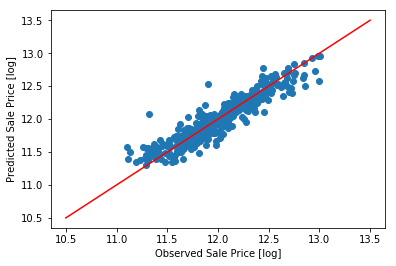

In [50]:
plt.scatter(Ytest, Ypred)
plt.xlabel("Observed Sale Price [log]")
plt.ylabel("Predicted Sale Price [log]")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

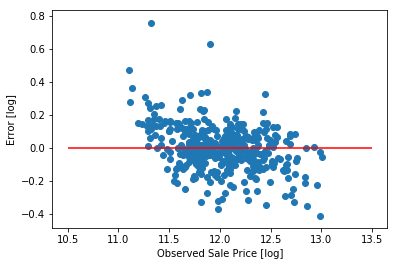

In [53]:
plt.scatter(Ytest, Ypred-Ytest)
plt.xlabel("Observed Sale Price [log]")
plt.ylabel("Error [log]")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()